#Sentiment Analysis: Extracting Emotions From Text Using Classic NLP

In [1]:
# Install required packages
!pip install vaderSentiment wordcloud

# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from collections import Counter
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Read the Sentiment140 dataset (CSV format) that was uploaded earlier as 'balanced_dataset.csv'
# Since the file has no header row, we manually set header=None and define column names later

df = pd.read_csv("balanced_dataset.csv")

df.columns = ['sentiment', 'text']
df = df[['sentiment', 'text']]

In [4]:
# Text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+|@\w+|#\w+", "", str(text))
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    return " ".join(w for w in text.split() if w not in stop_words)

# Clean tweets
df['clean_text'] = df['text'].apply(clean_text)

Dataset shape: (498576, 3)
Null values:
 sentiment     0
text          0
clean_text    0
dtype: int64
Class distribution:
 sentiment
0    250000
1    248576
Name: count, dtype: int64


<ipython-input-4-6c419623909e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


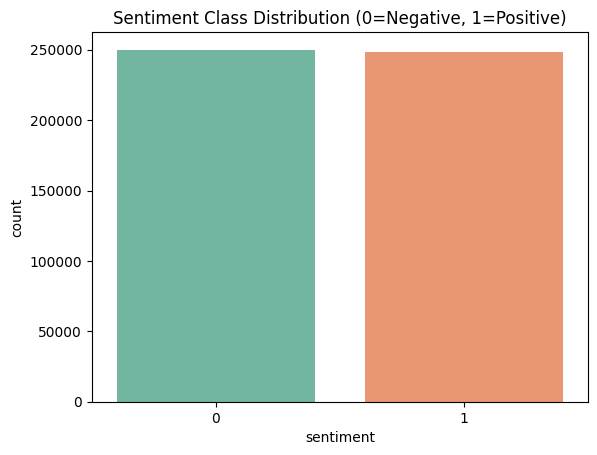

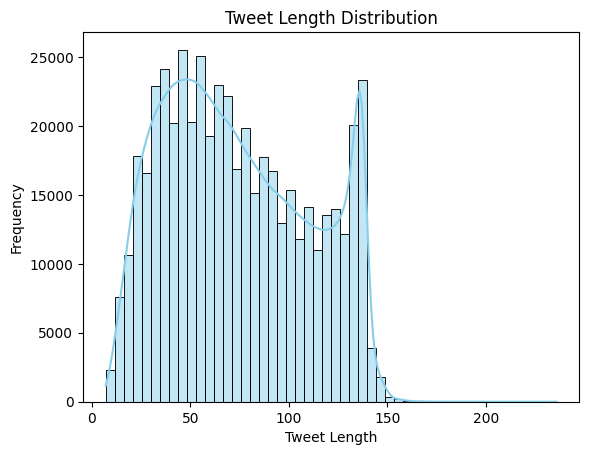

<ipython-input-4-6c419623909e>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=pos_df, ax=ax[0], palette='Greens_r')
<ipython-input-4-6c419623909e>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=neg_df, ax=ax[1], palette='Reds_r')


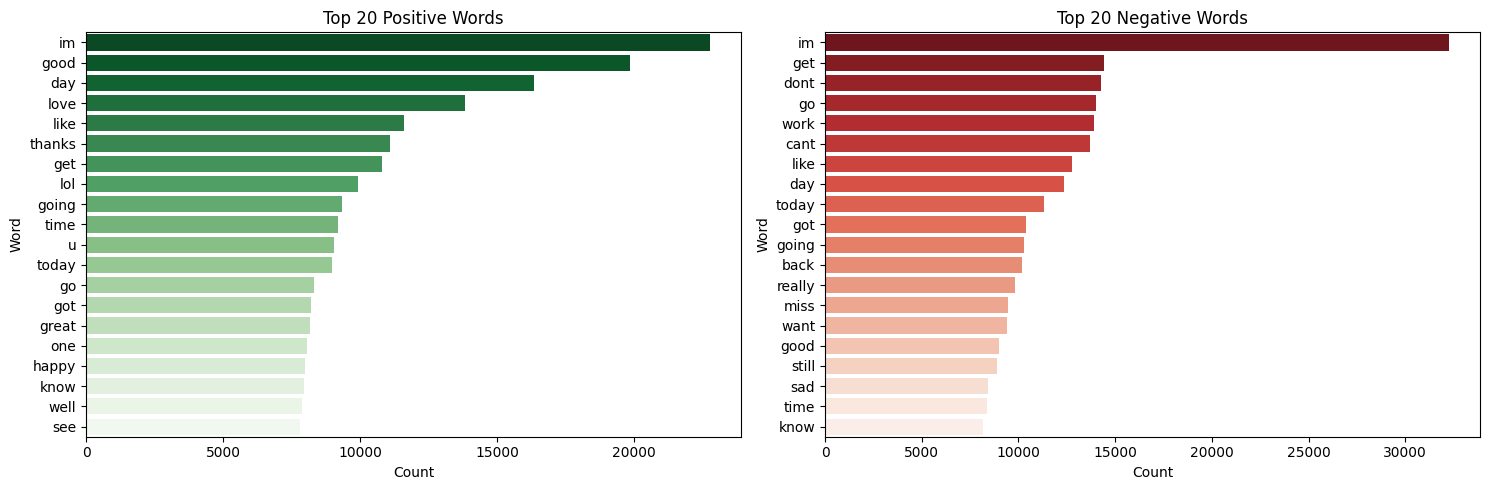

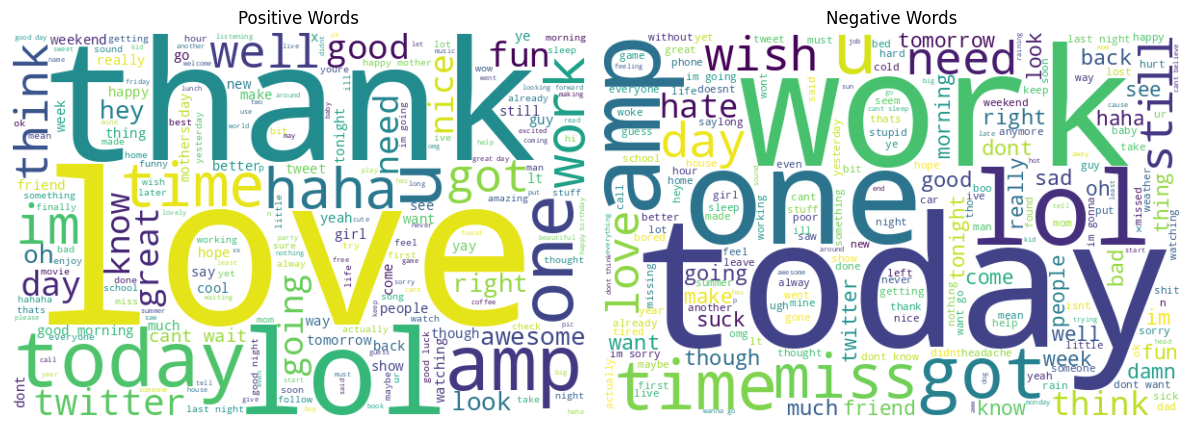

In [ ]:
# Basic stats
print("Dataset shape:", df.shape)
print("Null values:\n", df.isnull().sum())
print("Class distribution:\n", df['sentiment'].value_counts())

# Visualize class distribution
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Class Distribution (0=Negative, 1=Positive)")
plt.show()

# Tweet length distribution
df['text_len'] = df['text'].apply(len)
sns.histplot(data=df, x='text_len', bins=50, kde=True, color='skyblue')
plt.title("Tweet Length Distribution")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

def get_top_words(texts, n=20):
    words = " ".join(texts).split()
    return Counter(words).most_common(n)

neg_words = get_top_words(df[df['sentiment'] == 0]['clean_text'])
pos_words = get_top_words(df[df['sentiment'] == 1]['clean_text'])

neg_df = pd.DataFrame(neg_words, columns=['Word', 'Count'])
pos_df = pd.DataFrame(pos_words, columns=['Word', 'Count'])

# Plot top words
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='Count', y='Word', data=pos_df, ax=ax[0], palette='Greens_r')
ax[0].set_title("Top 20 Positive Words")

sns.barplot(x='Count', y='Word', data=neg_df, ax=ax[1], palette='Reds_r')
ax[1].set_title("Top 20 Negative Words")

plt.tight_layout()
plt.show()

# Word clouds
positive_words = " ".join(df[df['sentiment'] == 1]['clean_text'])
negative_words = " ".join(df[df['sentiment'] == 0]['clean_text'])

wordcloud_pos = WordCloud(width=600, height=400, background_color='white').generate(positive_words)
wordcloud_neg = WordCloud(width=600, height=400, background_color='white').generate(negative_words)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Words")
plt.axis("off")
print("")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Words")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Naive Bayes (TF-IDF) Classification Report:")
print(classification_report(y_test, y_pred))


Naive Bayes (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     50001
           1       0.77      0.74      0.76     49715

    accuracy                           0.76     99716
   macro avg       0.76      0.76      0.76     99716
weighted avg       0.76      0.76      0.76     99716



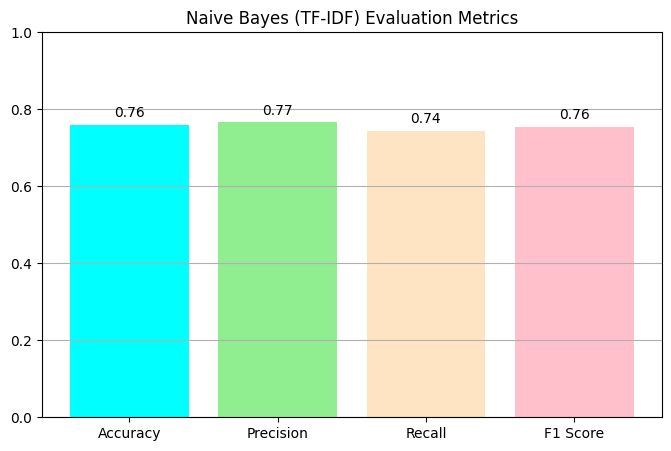

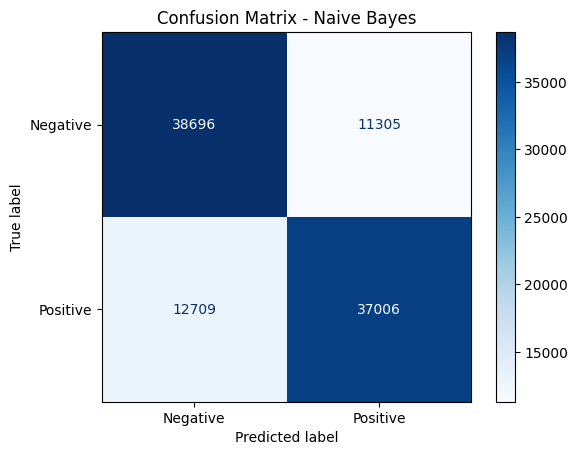

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Bar plot for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['cyan', 'lightgreen', 'bisque', 'pink'])
plt.ylim(0, 1)
plt.title("Naive Bayes (TF-IDF) Evaluation Metrics")
plt.grid(axis='y')

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')

plt.show()
print("\n")
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

VADER Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.43      0.56    250000
           1       0.61      0.90      0.73    248576

    accuracy                           0.66    498576
   macro avg       0.71      0.67      0.65    498576
weighted avg       0.71      0.66      0.65    498576



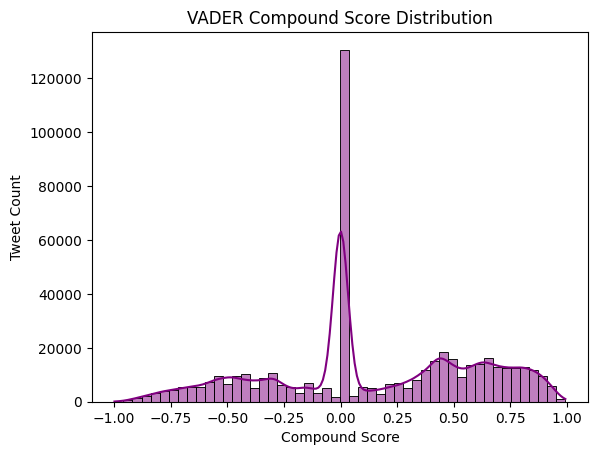

In [ ]:
# VADER sentiment analysis
analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    return 1 if score['compound'] >= 0 else 0

df['vader_pred'] = df['text'].apply(vader_sentiment)

# Evaluate VADER
print("VADER Classification Report:")
print(classification_report(df['sentiment'], df['vader_pred']))


# VADER score distribution
df['compound'] = df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

sns.histplot(df['compound'], bins=50, kde=True, color='purple')
plt.title("VADER Compound Score Distribution")
plt.xlabel("Compound Score")
plt.ylabel("Tweet Count")
plt.show()


In [ ]:
# Predict sentiment: Positive if compound >= 0, Negative otherwise
df['vader_pred'] = df['compound'].apply(lambda x: 1 if x >= 0 else 0)

# Create a separate DataFrame for evaluation
vader_df = df[['sentiment', 'vader_pred', 'compound']]
vader_df.columns = ['label', 'prediction', 'compound']

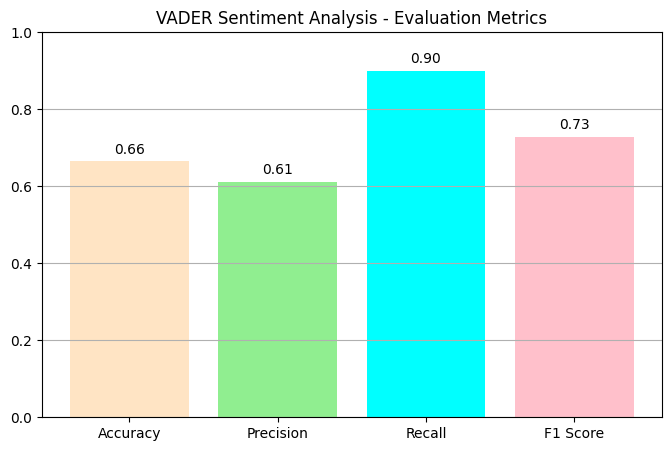

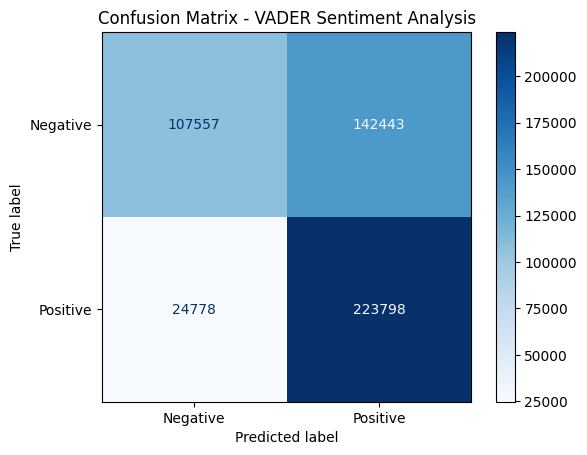

In [ ]:
# Calculate evaluation metrics
vader_accuracy = accuracy_score(vader_df['label'], vader_df['prediction'])
vader_precision, vader_recall, vader_f1, _ = precision_recall_fscore_support(
    vader_df['label'], vader_df['prediction'], average='binary')

# Bar plot for VADER metrics
vader_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
vader_values = [vader_accuracy, vader_precision, vader_recall, vader_f1]

plt.figure(figsize=(8, 5))
bars = plt.bar(vader_metrics, vader_values, color=['bisque', 'lightgreen', 'cyan', 'pink'])
plt.ylim(0, 1)
plt.title("VADER Sentiment Analysis - Evaluation Metrics")
plt.grid(axis='y')

# Annotate metric values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')

plt.show()
print("\n")

# Confusion matrix plot
vader_cm = confusion_matrix(vader_df['label'], vader_df['prediction'])
vader_disp = ConfusionMatrixDisplay(confusion_matrix=vader_cm, display_labels=['Negative', 'Positive'])
vader_disp.plot(cmap='Blues')
plt.title("Confusion Matrix - VADER Sentiment Analysis")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Model evaluation
models = {
    "Multinomial NB": MultinomialNB(),
    "Complement NB": ComplementNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier()
}

try:
    from xgboost import XGBClassifier
    xgb_installed = True
except ImportError:
    xgb_installed = False

if xgb_installed:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss')





Multinomial NB ---
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     50001
           1       0.77      0.74      0.76     49715

    accuracy                           0.76     99716
   macro avg       0.76      0.76      0.76     99716
weighted avg       0.76      0.76      0.76     99716


Complement NB ---
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     50001
           1       0.76      0.75      0.76     49715

    accuracy                           0.76     99716
   macro avg       0.76      0.76      0.76     99716
weighted avg       0.76      0.76      0.76     99716


Logistic Regression ---
              precision    recall  f1-score   support

           0       0.79      0.76      0.77     50001
           1       0.76      0.79      0.78     49715

    accuracy                           0.77     99716
   macro avg       0.78      0.77      0.77     99716
weighted a

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:19:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost ---
              precision    recall  f1-score   support

           0       0.80      0.65      0.72     50001
           1       0.70      0.83      0.76     49715

    accuracy                           0.74     99716
   macro avg       0.75      0.74      0.74     99716
weighted avg       0.75      0.74      0.74     99716



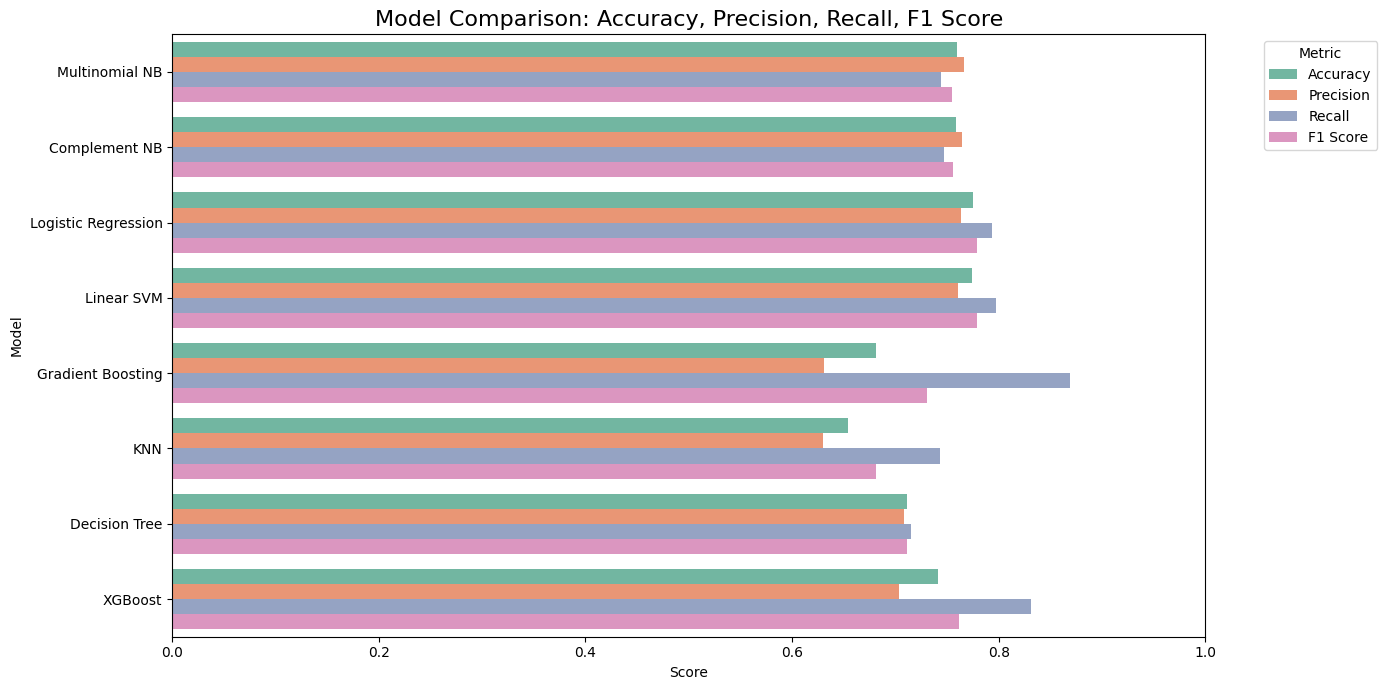

In [ ]:

# Initialize results dict
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

trained_models = {}

# Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)
    results["F1 Score"].append(f1)

    trained_models[name] = model
    print(f"\n{name} ---")
    print(classification_report(y_test, y_pred))

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Melt the DataFrame to long format for easier plotting
results_long = pd.melt(results_df, id_vars=["Model"], var_name="Metric", value_name="Score")

# Plot grouped bar chart
plt.figure(figsize=(14, 7))
sns.barplot(x="Score", y="Model", hue="Metric", data=results_long, palette="Set2")
plt.title("Model Comparison: Accuracy, Precision, Recall, F1 Score", fontsize=16)
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import re
import string

# Define cleaning function for single input
def clean_input(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Predictor function
def predict_sentiment(input_text, model_name="Logistic Regression"):
    model = trained_models[model_name]
    cleaned = clean_input(input_text)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    return "Positive" if prediction == 1 else "Negative"

# Interactive loop
print("\nSentiment Predictor Ready! (Type 'exit' to stop)\n")
while True:
    user_input = input("Enter a sentence: ")
    if user_input.lower() == "exit":
        break
    output = predict_sentiment(user_input, model_name="Logistic Regression")
    print(f"Sentiment: {output}\n")



Sentiment Predictor Ready! (Type 'exit' to stop)

Enter a sentence: hello
Sentiment: Positive

Enter a sentence: she's dead
Sentiment: Negative

Enter a sentence: hes happy
Sentiment: Positive

Enter a sentence: exit
